11/12/2021 Fathan Baihaqy

# GET TRYNING DATA

Return rawData (Raw Data), comData(Compound Data), fgrData (FingerPrint Data), and generate data and general drug Chemical Propertirs

### Install and Load Modules

In [ ]:
#chEMBL (Request Database)
! pip install chembl_webresource_client

#rdkit (Chemical Analysis)
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local

! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

#Molecular FInger Print
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
! unzip padel.zip

In [ ]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Request
organism = "Mycobacterium tuberculosis"
target   = "CHEMBL1849"
standard = "IC50"

# Labeling
inactive_limit     = 10_000
intermediate_limit = 1_000

# Calculation
log_limit    = 100_000_000

In [ ]:
# Number of Data
n_initial    = False
n_computable = False

# Compound activity
n_active       = False
n_intermediate = False
n_inactive     = False

### Request Data and Filtering

Requiere Internet collection to request data from https://www.ebi.ac.uk/chembl/, database of bioactive molecules with drug-like properties and
Filtering data with IC50 test standard

In [ ]:
# Get Target data with spesify standard --> rawData
rawData = new_client.activity
rawData = rawData.filter(target_chembl_id = target )
rawData = rawData.filter(standard_type=standard)
rawData = pd.DataFrame(rawData)

# calculate number of rawData
n_initial    = len(rawData)

# Save rawData
rawData.to_csv(f"00 rawData {target} {organism}.csv", index=False)
len(rawData)

410

In [ ]:
# Drop Duplicate in Data (molecule duplicate) and select column --> comData
selected_val = ['molecule_chembl_id','canonical_smiles','standard_value']
comData = rawData.drop_duplicates(['canonical_smiles'])
comData = comData[selected_val]
comData.dropna(inplace=True)
comData = comData.reset_index()

# calculate number of comData
n_computable     = len(comData)

### Value Labeling and Convertion

Calculate normalize standard value, pIC50, Molecular Weight, LogP, Proton Donor, and proton acceptor 

In [ ]:
# Categorize compound base on <standard_value>
for idx in comData.index:
    val = float(comData.standard_value[idx])
    if val >= inactive_limit:
        cat = "inactive"
    elif val >= intermediate_limit:
        cat = "intermediate"
    else:
        cat = "active"
    comData.loc[idx, "class"] = cat

In [ ]:
# Calculate normalize <standard_value> -> <standard_value_norm>
for idx in comData.index:
    val = comData.loc[idx,"standard_value"]
    if float(val) > log_limit:
        val = log_limit
    comData.loc[idx,"standard_value_norm"] = val

In [ ]:
# Calculate pIC50
for idx in comData.index:
    molar = float(comData.loc[idx,'standard_value_norm'])*(10**-9) #nM to M
    comData.loc[idx,"pIC50"] = -np.log10(molar)

In [ ]:
# Chemical Properties

for idx in comData.index:
  try:
    mol = Chem.MolFromSmiles(comData.canonical_smiles[idx])
  except:
    print(comData.canonical_smiles[idx],"Fail")
  comData.loc[idx,"MolWt"]         = Descriptors.MolWt(mol)
  comData.loc[idx,"MolLogP"]       = Descriptors.MolLogP(mol)
  comData.loc[idx,"NumHDonors"]    = Lipinski.NumHDonors(mol)
  comData.loc[idx,"NumHAcceptors"] = Lipinski.NumHAcceptors(mol)

In [ ]:
comData.to_csv(f"01 comData {target} {organism}.csv")

### FingerPrint Calculation

In [ ]:
data = comData[ ['canonical_smiles','molecule_chembl_id'] ]
data.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
#! cat padel.sh
! bash padel.sh

In [ ]:
fgrData = pd.read_csv('descriptors_output.csv')
fgrData = fgrData.drop(columns=["Name"])
fgrData = pd.concat([fgrData,comData["pIC50"]], axis=1)

#Menyimpan Data
fgrData.to_csv(f"02 fgrData {target} {organism}.csv", index=False)

### General Properties of Data

##### Function

In [ ]:
#Menentukan Signifikasi
def mannwhitney(descriptor, data, alpha=0.05, verbose=False):
  # seed the random number generator
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu
  seed(1)

  # actives and inactives
  selection = [descriptor, 'class']
  df = data[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = data[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)


# interpret
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  print(f"Statistik: {str(stat).rjust(7)}  |  p:{str(round(p,2)).rjust(5)}  |  alpha: {alpha}  |  Interpretation: {interpretation}")



In [ ]:
def boxplot_com(data, y, x='class'):
  plt.figure(figsize=(5.5, 5.5))
  sns.boxplot(x=x, y=y, data = data)
  plt.xlabel(f'Bioactivity {x}', fontsize=14, fontweight='bold')
  plt.ylabel(y, fontsize=14, fontweight='bold')
  plt.savefig(f'plot_{y}.pdf')

In [ ]:
def stem_diagram(data):
  plt.figure(figsize=(5.5, 5.5))
  sns.countplot(x='class', data=data, edgecolor='black')
  plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
  plt.ylabel('Frequency', fontsize=14, fontweight='bold')

In [ ]:
def scatter(data, xVal, yVal):
  plt.figure(figsize=(5.5, 5.5))
  sns.scatterplot(x=xVal, y=yVal, data=data, hue='class', size='pIC50', edgecolor='black', alpha=0.7)
  plt.xlabel(xVal, fontsize=14, fontweight='bold')
  plt.ylabel(yVal, fontsize=14, fontweight='bold')
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

##### **Result**

###### Activity

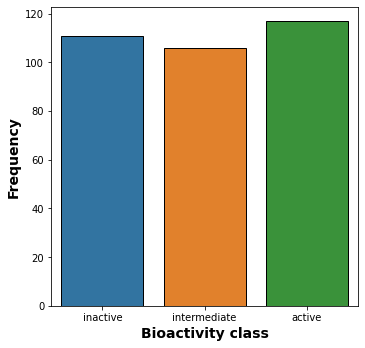

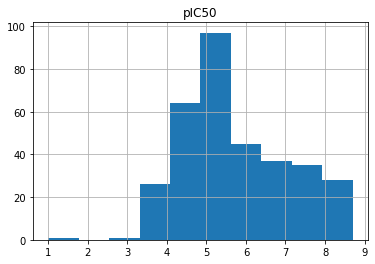

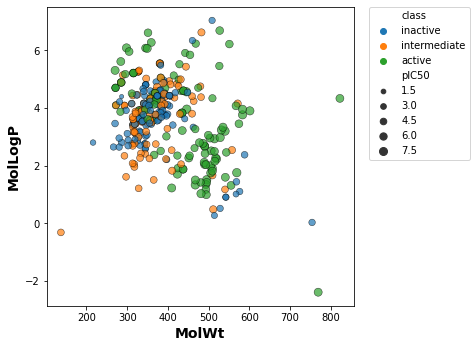

In [ ]:
#@title
stem_diagram(comData)
comData.hist(column="pIC50")
scatter(comData,'MolWt', 'MolLogP')

n_active       = len(comData.loc[comData["class"] == "active"] )
n_intermediate = len(comData.loc[comData["class"] == "intermediate"] )
n_inactive     = len(comData.loc[comData["class"] == "inactive"] )

###### Molecular Properties

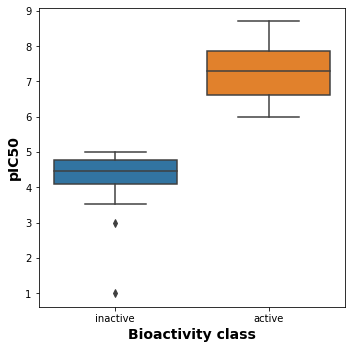

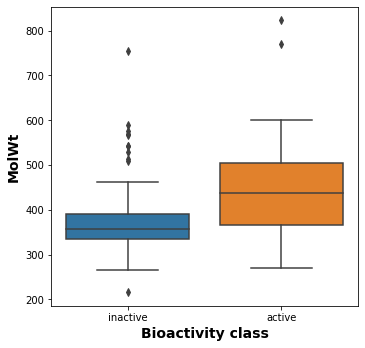

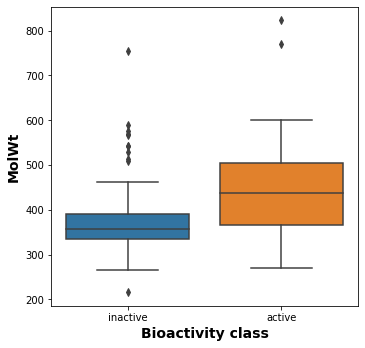

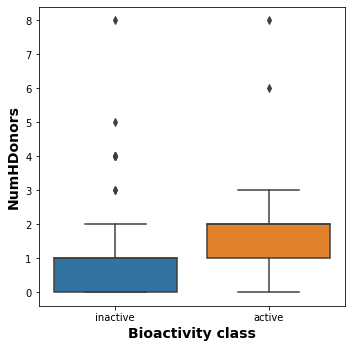

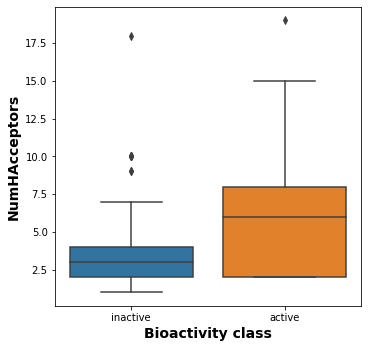

In [ ]:
#@title
data = comData.loc[comData['class'] != 'intermediate']
var = ["pIC50", "MolWt", "MolWt", "NumHDonors", "NumHAcceptors"]
for val in var:
  boxplot_com(data, val)
  #mannwhitney(val, data)

###### Data Properties

In [ ]:
#@title
txt = f"""
n_initial      = {n_initial}
n_computable   = {n_computable}
n_active       = {n_active}
n_intermediate = {n_intermediate}
n_inactive     = {n_inactive}
"""
print(txt)


n_initial      = 410
n_computable   = 334
n_active       = 117
n_intermediate = 106
n_inactive     = 111

